### Tweets and User Analysis

Let's try to do an in-depth analysis of tweets and users!
- Build a retweet / mention network
- This could later help with identifying tweets aimed at stirring up controversy
- Seperate content providers from content pushers using retweet count etc.

#### Preprocessing

##### Users
What do we suspect the goal of the Russian operation to be?
- Polarization can only be pushed from the inside! 
- Even the most malleable American will be suscpicous (hopefully) about tweets from users outside of the US on US topics
- We should thus focus on these "content" providers who are pretending to be normal US citizens 
- Remove tweets that contain cyrillic
- Remove users who are self reported to be from Russia
- This includes all these news channels etc
- Highly likely that the IRA also operates domestically, trying to shape Russian opinions
- Zone in on these high reach, fictitcous-american content provider tweets

##### Text
- Hashtags are important, they convey lots of meaning and can be seen as a topic proxy. Could store them in a different section, outside of pure text (note: they are already in the dataframe as a seperate column!) 
- Same holds for mentions and retweets
- Lowercase, remove punctuation
- Remove stopwords 
- Ngrams?
- Stemming
- Lemmatization?

Break the texts down to their core. Polarization is probably going to manifest itself as the joint occurence of decisive topics and strong opinions on it. At least we can try to identify the topics and then get an idea about the sentiment.

What's really annoying is that we ONLY have this Russian data. We don't have any data from the center of the political spectrum.

### Data Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import regex

# Own defined functions (see utils folder)
from utils.cleaning import has_cyrillic, has_arabic

In [3]:
plt.rcParams['figure.figsize'] = (12,10)

In [4]:
# Data loading
tweet_data = pd.read_csv("../data/ira_tweets_en.csv")
user_data = pd.read_csv("../data/ira_users_csv_hashed.csv")

/home/adam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Let's filter out tweets with cyrillc texts
is_cyrillic = tweet_data["tweet_text"].apply(has_cyrillic)

# Remove tweets with cyrillic 
tweet_data = tweet_data[np.invert(is_cyrillic)]


# Getting all the users who tweet in english, cuts down by 600
user_data = user_data[user_data["userid"].isin(tweet_data.userid.unique())].copy()

### Analysis and Cleaning (except tweets)

Let's start with checking the tweet data columns:

In [8]:
tweet_data.columns

Index(['Unnamed: 0', 'tweetid', 'userid', 'user_display_name',
       'user_screen_name', 'user_reported_location',
       'user_profile_description', 'user_profile_url', 'follower_count',
       'following_count', 'account_creation_date', 'account_language',
       'tweet_language', 'tweet_text', 'tweet_time', 'tweet_client_name',
       'in_reply_to_tweetid', 'in_reply_to_userid', 'quoted_tweet_tweetid',
       'is_retweet', 'retweet_userid', 'retweet_tweetid', 'latitude',
       'longitude', 'quote_count', 'reply_count', 'like_count',
       'retweet_count', 'hashtags', 'urls', 'user_mentions', 'poll_choices'],
      dtype='object')

- Tweetid: Just the Id, no meaningful information except maybe for retweets
- UserId: Identifier
- User_disply_name: Some of them are hashed, so we'll only gain info from the non-hashed ones
- User_screen_name & user_reported_location: We can take out tweets whose user report to be outside of the US
- Description and URL: Descripitons are meaningful, could contain information, URL is useless for now
- Follower and following count: Very important for reach 
- Language: Helps us to filter stuff
- Tweet text: Core of our analysis, will dive deeper into preprocessing later
- Tweet_time: UTC time, only in joint analysis with true location useful
- In_reply_to{}: Super useful to establish patterns, but could be hard to make use of without considerable network analysis 
- Quoted: See in_reply_to
- Is retweet: helps us to clean the data
- Latitutde, Longitude: We could make a sexy visualization out of this, will be hard though
- Quote, reply, like count, retweet count: Impact factors
- Hashtags: Super useful for identifying topics

Now for the user data:

In [9]:
user_data.columns

Index(['userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language'],
      dtype='object')

These contain mostly aggregate information on location, description and so on. There is no additional information over the tweets data as far as I can tell. I'll now dive into the single columns and start cleaning / preprocessing on the go.

#### User Description 
I will take the user_data for this, so that I don't need to aggregate on tweets.

- Clean user description
- Remove cyrillic user descriptions
- Analyze words in descriptions
- Try to cluster / group

Notes:
- Some of them are also German, French and so on.
- We'll also need to deal with that.

Some interesting guys (with ID):
- 108: "Print Hillary's face  Pee on it  Send us proofs  Earn money" -> Some Russian TRoll had a good day :D
- 42: "Constitutional Conservative, member of the counterjihad, am against islam and sharia law, sick and tired of politcal correctness, diversity and multiculturalism"
- 217: "#American Patriot #Conservative •Political Blogger •#tcot •Proud Husband of @_SherylGilbert #InGodWeTrust"
- 215: "'I live my own life, #blacktivist'"
- 709: "white people are the most blood thirsty savages the world has ever seen #BLM #ICantBreath"
- 26: "We speak for all fellow members of LGBT community across the nation. Gender preference does not define you. Your spirit defines you."
- 2326: "TX patriots united for real action. GET READY TO SECEDE! #2A  #Texit #TexasSecede #Texodus" -> I mean this guy actively calls for secession, if that's not polarizing then I don't know what is.

Okay very cool, we can already see the polarizing tendencies in this data!

What really confuses me, which was also mentionde in some of the intelligence services analysis are these "mindfulness", "woke" and "free spirit" accounts like these:

- 2957: 'I have learned over the years that when one’s mind is made up, this diminishes fear.'
- 2652: "I give thanks everyday that I've been able to take my craziness and make it work for me."
- 3019: "Be the change that you wish to see in the world"
- 2810: "'I will not drown in the rising tide of conformity. I will not let authority ignore me. #staywoke ☯'"
- 1146: 'To live is the rarest thing in the world. Most people exist, that is all'

Maybe these are supposed to piss of conservatives?

Here's an idea:
- We go through (some of) the 3000 users (shouldn't take too long) and classify them by hand!
- Train some model on the profile descriptions, clustering by political party
- Then use this model to cluster the actual tweets!

Let's first clean the user data based on cyrillic descriptions and later locations!

Some of the profile descriptions are NaN. I will skip these for now.

In [10]:
user_data.user_profile_description.sample(10)

1068                      я просто человек, я просто живу
1945           Руководитель штаба ВОО МГЕР района Капотня
848     I make privileged people upset #BlackLivesMatt...
1738    We must believe that we are gifted for somethi...
537                                                   NaN
850                                                   NaN
2370    Руководитель ВОО Молодая Гвардия Единой России...
1295                                                  NaN
2885                                                  NaN
3300                                                 LOVE
Name: user_profile_description, dtype: object

In [13]:
# Fill NaN values
user_data["user_profile_description"].fillna(value="NaN",inplace = True)

In [14]:
# Checking that it works as intended to:
print(user_data["user_profile_description"].values[0:10])

print([has_cyrillic(desc) for desc in user_data["user_profile_description"].values[0:10]])

['Conservative. Politics. Pro-Life. Writer.  #GodBlessAmerica #WakeUpAmerica #InGodWeTrust'
 'На воре и шапка горит' '❥ ❣ my sweethearts))' 'NaN' 'NaN' 'NaN'
 '#Camden #CamdenNewJersey #NewJersey #USA #America #US #CamdenEvents #CamdenNews'
 'NaN' 'NaN' 'NaN']
[False, True, False, False, False, False, False, False, False, False]


In [15]:
# Filter
mask_cyrillic_desc = user_data["user_profile_description"].apply(has_cyrillic)

print(f"Nr. of users with cyrillic descriptions: {np.sum(mask_cyrillic_desc)}")

Nr. of users with cyrillic descriptions: 818


In [16]:
# Filtering users based on cyrillic profile descriptions.
user_data = user_data.loc[np.invert(mask_cyrillic_desc),].copy()

Now that we've filtered the profile descriptions in cyrillic we can check for the reported languages. Then we filter for only english ones.

#### Reported Account Language

In [17]:
user_data.groupby("account_language").count()["userid"]

account_language
ar         18
de         91
en       1961
en-gb       5
es          8
fr         10
id          1
it          7
ru        136
zh-cn       3
Name: userid, dtype: int64

Okay nice, we have 1961 supposedly english accounts. Let's again filter all the others out. 

In [18]:
user_data = user_data[user_data.account_language == "en"].copy()

#### Locations

Now it's time to check on the locations.

In [19]:
user_data.shape

(1961, 10)

In [21]:
reported_locations = user_data.groupby(user_data.user_reported_location).count()["userid"].sort_values(ascending= False)
reported_locations

user_reported_location
USA                          643
United States                105
Atlanta                       73
US                            60
New York, USA                 41
NY                            33
LA                            29
Boston                        22
New York, NY                  18
New York                      17
Los Angeles                   15
Atlanta, GA                   14
Chicago                       12
Philadelphia                   9
Phoenix                        8
Chicago, IL                    8
Texas, USA                     7
Houston, TX                    7
Arizona                        7
Москва                         7
دمشق                           7
New York City                  6
New-York                       6
London                         6
Los Angeles, CA                6
Washington, DC                 6
Syria                          6
Washington                     5
Washington, D.C.               5
Dallas              

Again some cyrillic or even arabic locations.

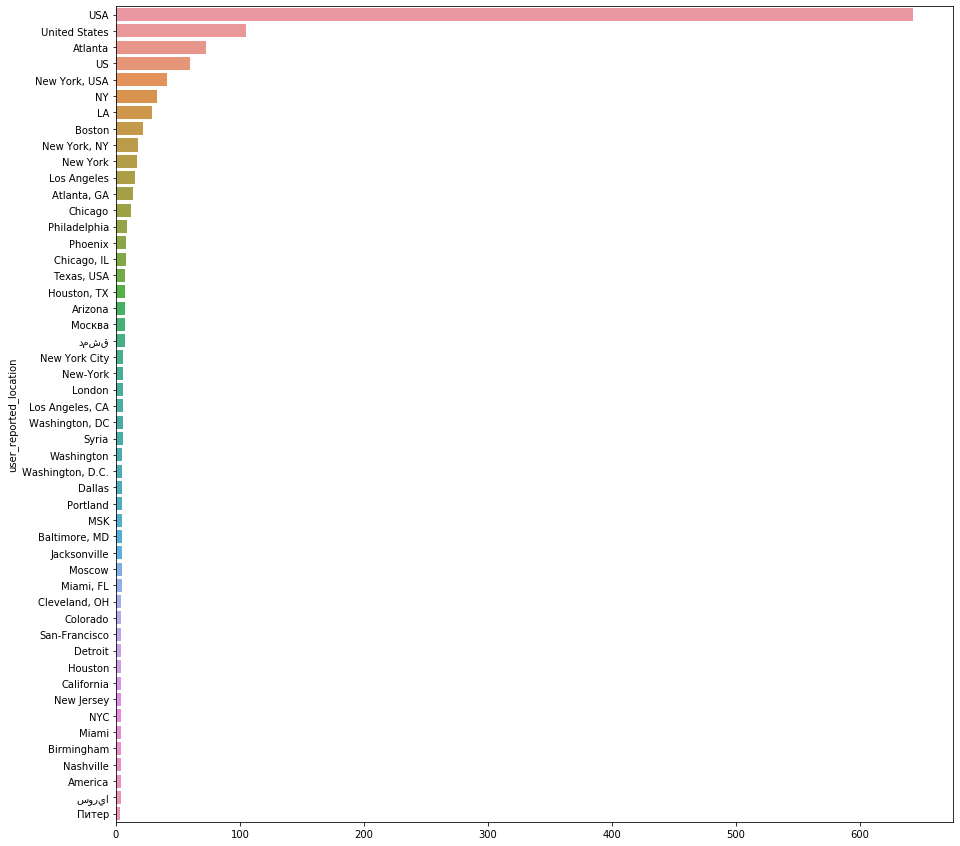

In [22]:
plt.figure(figsize=(15, 15))
sns.barplot(y= reported_locations.iloc[0:50].index, x=reported_locations.iloc[0:50].values);

Again, we'll filter out non-latin letters.

In [23]:
# Check for letters
non_latin_locations= [has_arabic(loc) | has_cyrillic(loc) for loc in reported_locations.index]
print(f"{np.sum(non_latin_locations)} non-lation location descriptions")

35 non-lation location descriptions


In [24]:
# Filter out
user_data = user_data[user_data["user_reported_location"].isin(reported_locations.index[np.invert(non_latin_locations)])].copy()
print(f"{user_data.shape[0]} users left after strict cleaning")

1560 users left after strict cleaning


This has cut down the number of users by almost half! Let's see the impact on the tweets.

In [25]:
print(f"Tweets left: {tweet_data[tweet_data.userid.isin(user_data.userid.values)].shape[0]}")

Tweets left: 2536417


In [27]:
tweet_data = tweet_data[tweet_data.userid.isin(user_data.userid.values)].copy()

Fine, still 2.5 million tweets, while getting rid of potentially uninformative russian tweets.

Let's now dive into the actual tweet data.

### Tweet Data

I'll start with very basic observations:
- Most shared tweets
- Accounts with the most followers
- Accounts who post the most vs. accounts with many retweets


#### The most shared tweets
- In terms of retweet, quote, reply and like counts.

In [28]:
most_quoted = tweet_data.sort_values(by="quote_count", ascending=False)[["user_display_name","tweet_text","quote_count"]]
most_retweeted = tweet_data.sort_values(by="retweet_count", ascending=False)[["user_display_name","tweet_text","retweet_count"]]
most_replies = tweet_data.sort_values(by="reply_count", ascending=False)[["user_display_name","tweet_text","reply_count"]]
most_liked = tweet_data.sort_values(by="like_count", ascending=False)[["user_display_name","tweet_text","like_count"]]

In [29]:
pd.set_option('max_colwidth', 200)
most_quoted.iloc[0:10,][["tweet_text","quote_count"]]

,tweet_text,quote_count
466485,This adorable baby boy's smile is going to completely warm your heart. https://t.co/TWveXVtsJ7,11633.0
2052800,Watch what happens when this big brother spots his little sister after getting off the school bus. It's priceless ❤ https://t.co/DKO2X3NMWa,8765.0
966349,"Nigerian Physician, Dr. Oluyinka Olutoye cut a woman baby out her womb at 23 weeks old, successfully operated on the baby after taking out a tumor, then placed the baby back into the mum's womb &a...",7901.0
2792181,You probably didn't learn this in school: https://t.co/izSRhALylm,7808.0
2080950,Man Gives WAITER a $300 TIP and CRIES! https://t.co/ePU9kl3M8M,7508.0
2313814,For those who support #AltonSterling isn’t it a problem that he had a criminal record and was a convinced pedophile? https://t.co/UedQtzFlzb,6974.0
2953216,These emotions... You can hear the pain in her voice😢 https://t.co/K98Fzep7K3,6196.0
440440,"Oregon man who followed a Black Muslim couple for 20 blocks, yelling racial slurs at them, burst into tears after he was charged with a hate crime. My favorite type of bigot is the crying bigo...",6082.0
2021761,Stop what you're doing and watch these 3-year-old preschoolers confidently (and cutely) spell their names. 😍 https://t.co/uhyAGMwtTN,5190.0
264454,This is so cute! 💘 Daddy made sure to learn his daughter's whole routine in case she forgot. 😍 https://t.co/tHejwGSDUH,4595.0


In [30]:
most_retweeted.iloc[0:10,][["tweet_text","retweet_count"]]

,tweet_text,retweet_count
2196656,Daily reminder that the most educated First Lady in American history is a black woman with two Ivy League degrees from Harvard and Princeton https://t.co/oTBTmu2tCw,123617.0
1983663,Obama (2012) sits alone in a classroom after meeting for hours with parents of Sandy Hook victims. Trump (2018) sits at a disco party he threw at his private night club after spending 14 minutes...,113066.0
2953216,These emotions... You can hear the pain in her voice😢 https://t.co/K98Fzep7K3,97498.0
966349,"Nigerian Physician, Dr. Oluyinka Olutoye cut a woman baby out her womb at 23 weeks old, successfully operated on the baby after taking out a tumor, then placed the baby back into the mum's womb &a...",86619.0
466485,This adorable baby boy's smile is going to completely warm your heart. https://t.co/TWveXVtsJ7,74524.0
1852222,"""This is what white people get to feel like ALL THE TIME?!"" https://t.co/cMvvyNF8gN",65564.0
2052800,Watch what happens when this big brother spots his little sister after getting off the school bus. It's priceless ❤ https://t.co/DKO2X3NMWa,59292.0
62043,Don’t ever tell me kneeling for the flag is disrespectful to our troops when Trump calls a sitting Senator “Pocahontas” in front of Native American war heroes.,51472.0
1722561,"If this little girl's way of reminding her dad to hold her hand isn't one of the cutest 10 seconds of video you've ever seen.. ""Excuse me.""😍 https://t.co/oCrbnCpI0u",51285.0
1069216,This powerful video shows the conversations Black parents give to kids navigating racism https://t.co/cuCtPBSy7v,50217.0


In [ ]:
most_replies.iloc[0:10,][["tweet_text","reply_count"]]

In [ ]:
most_liked.iloc[0:10,][["tweet_text","like_count"]]

Some observations:
- Huge overlap between the 4 metrics
- Most of them are clearly in either of the directions

### Differentiating between content creators and amplifiers

This is going to be a bit tricky but should help with the text analysis later on.
- Check number of retweets by user
- If the number of retweets as fraction of overall tweets exceeds a certain threshold we can think of these accounts as bots aimed at amplifing the impact


In [31]:
# Percentage of retweets over all tweets by user
retweet_percentage = tweet_data.groupby([tweet_data.userid]).mean()["is_retweet"]

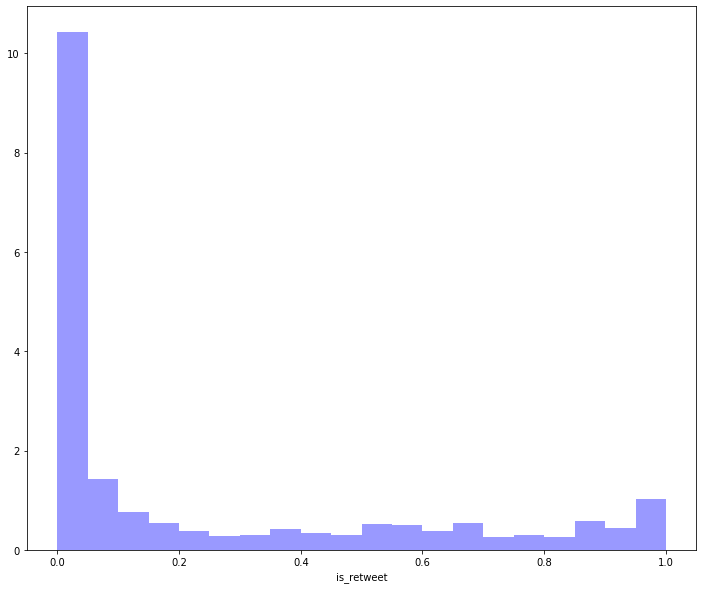

In [32]:
# Let's see the distribution of the retweet percentage
sns.distplot(retweet_percentage, kde=False, bins=20,color ="blue",norm_hist=True);

Interesting again. Some users only retweet, others never retweet. Let's visualize this by number of tweets in total.

In [33]:
no_tweets = tweet_data.groupby("userid").count()["tweetid"]

Text(0, 0.5, 'Log of Total Nr. of Tweets')

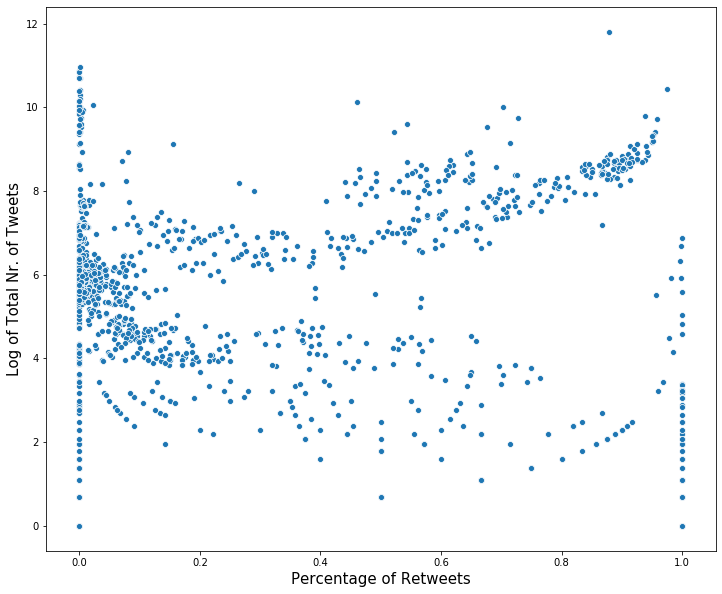

In [34]:
h = sns.scatterplot(y = np.log(no_tweets.values), x= retweet_percentage.values)
h.set_xlabel("Percentage of Retweets",fontsize = 15)
h.set_ylabel("Log of Total Nr. of Tweets",fontsize = 15)

Let's see the same thing by follower count:

In [35]:
tweet_data.follower_count.max()

79152

In [37]:
tweet_data[tweet_data.follower_count==79152]

,Unnamed: 0,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,...,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices
19,105,626740121648259072,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common sense. Any offers/ideas/questions? DM or email me jennnabrams@gmail.com (Yes, there are 3 Ns)",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,0.0,2.0,1.0,"[IfAnimalsMadeLaws, EqualityForAll]",[],NaN,NaN
20,106,851098834176487428,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common sense. Any offers/ideas/questions? DM or email me jennnabrams@gmail.com (Yes, there are 3 Ns)",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,5.0,13.0,12.0,13.0,[],[],NaN,NaN
21,107,851825187267989505,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common sense. Any offers/ideas/questions? DM or email me jennnabrams@gmail.com (Yes, there are 3 Ns)",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,1.0,5.0,14.0,7.0,[],[],NaN,NaN
22,108,681897201761697792,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common sense. Any offers/ideas/questions? DM or email me jennnabrams@gmail.com (Yes, there are 3 Ns)",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,100.0,550.0,610.0,[],[],NaN,NaN
23,109,662532293613875201,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common sense. Any offers/ideas/questions? DM or email me jennnabrams@gmail.com (Yes, there are 3 Ns)",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,0.0,1.0,0.0,[],[],"[3296320187, 164332083]",NaN
24,110,668044460224188416,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common sense. Any offers/ideas/questions? DM or email me jennnabrams@gmail.com (Yes, there are 3 Ns)",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,3.0,15.0,12.0,[offensive],[],NaN,NaN
25,111,835506064493850625,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common sense. Any offers/ideas/questions? DM or email me jennnabrams@gmail.com (Yes, there are 3 Ns)",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,9.0,13.0,69.0,50.0,[],[],NaN,NaN
26,112,607812929568636928,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common sense. Any offers/ideas/questions? DM or email me jennnabrams@gmail.com (Yes, there are 3 Ns)",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,0.0,0.0,0.0,[],[],[742143],NaN
27,113,728636801242566657,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common sense. Any offers/ideas/questions? DM or email me jennnabrams@gmail.com (Yes, there are 3 Ns)",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,5.0,59.0,34.0,[BodyAcceptance],[],NaN,NaN
28,114,586136580500226048,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common sense. Any offers/ideas/questions? DM or email me jennnabrams@gmail.com (Yes, there are 3 Ns)",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,0.0,0.0,3.0,[morningjoe],[],NaN,NaN


In [ ]:
h = sns.scatterplot(y = tweet_data.groupby("userid").mean()["follower_count"], x= retweet_percentage.values)
h.set_xlabel("Percentage of Retweets",fontsize = 15)
h.set_ylabel("Nr. of Followers",fontsize = 15)

Looks like the original content providers have a higher follower count on average.

I think I'll have to start working with the text itself now, otherwise I wont get much meaningful information out of this.

### The Tweets

Preprocessing first!

1. Convert to lowercase
2. Remove retweets, mentions, emojis, hashtags, links
3. Stemming or Lemmatization

Embedding later!

In [40]:
# Text mining packages
import spacy
from bs4 import BeautifulSoup
import nltk

# Import cleaning function
from utils.cleaning import clean_tweet

clean_new = False

In [41]:
if clean_new == True:
    
    # Clean the tweets
    tweets_clean = tweet_data["tweet_text"].apply(clean_tweet)
    

    # Add it to the data frame and save it, so that we won't need to run this again
    tweet_data["tweet_text_clean"] = tweets_clean

    # Write to file
    tweet_data.to_csv("../data/ira_tweets_clean.csv")

else:
    # Load cleaned tweets 
    tweet_data = pd.read_csv("../data/ira_tweets_clean.csv")

/home/adam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
# Lemmatization

# Loading english language
nlp = spacy.load("en")

# Lemmatize, remove stop words and remove punctuation
def lemmatize(s):
    doc = nlp(s)
    s = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]

    # Join back to string
    s = ' '.join([w for w in s])
    
    return s

In [62]:
i = 1011
print(tweet_data.tweet_text[i])
print(tweet_data.tweet_text_clean[i])
print(lemmatize(tweet_data.tweet_text_clean[i]))

RT @TruthFeedNews: REPORT: Podesta and Wasserman-Schultz May Have Perjured Themselves https://t.co/xsi1YVjJQ7 via @truthfeednews #maga #tru…
  repo: podesta and wasserman-schultz may have perjured themselves  via   …
   repo podesta wasserman schultz perjure     


Okay this seems to strong, I can't make out the meaning anymore. For exaqmple, we're dropping "again" which is super important for "make america great again". Need to think of something smarter.


Actually, these guys: https://link.springer.com/chapter/10.1007/978-3-319-09339-0_62 argue that lemmatization and stemming lead to worse performance in terms of sentiment analysis, while features reservation, negation transformation and repeated letters normalization improves it. They also get better results when by using bigrams and emotions features.


https://www.sciencedirect.com/science/article/pii/S1877050913001385

In [39]:
tweet_data.hashtags.unique()

array([nan, '[USA]', '[]', ..., '[GetInTune]', '[FAMU, HBCU, college]',
       '[ArticleV, TermLimits, PJNET]'], dtype=object)